### Driver Lifetime Analysis

Author - Rithvik Mundra

Date : 8 Oct 2023

Updated date - 22 Oct 2023

Data Challenge - https://platform.stratascratch.com/data-projects/driver-lifetime-value

In [227]:
### Loading all the necessary libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

#clustering
from sklearn.cluster import KMeans

### Ingesting the datassts

In [ ]:
!pwd

/Users/rithvik/Documents/DS/Stratascratch/Data Projects/Driver Lifetime Value - Lyft


In [3]:
driver_ids = pd.read_csv("datasets/driver_ids.csv")
driver_ids

driver_id  driver_onboard_date
0    002be0ffdc997bd5c50703158b7c2491  2016-03-29 00:00:00
1    007f0389f9c7b03ef97098422f902e62  2016-03-29 00:00:00
2    011e5c5dfc5c2c92501b8b24d47509bc  2016-04-05 00:00:00
3    0152a2f305e71d26cc964f8d4411add9  2016-04-23 00:00:00
4    01674381af7edd264113d4e6ed55ecda  2016-04-29 00:00:00
..                                ...                  ...
932  ff419a3476e21e269e340b5f1f05414e  2016-04-26 00:00:00
933  ff714a67ba8c6a108261cd81e3b77f3a  2016-03-28 00:00:00
934  fff482c704d36a1afe8b8978d5486283  2016-04-08 00:00:00
935  fffecccc49436c5389075b13209f0dfa  2016-05-06 00:00:00
936  ffff51a71f2f185ec5e97d59dbcd7a78  2016-05-04 00:00:00

[937 rows x 2 columns]

In [4]:
ride_ids = pd.read_csv("datasets/ride_ids.csv")
ride_ids

driver_id                           ride_id  \
0       002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1       002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2       002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3       002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4       002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   
...                                  ...                               ...   
193497  ffff51a71f2f185ec5e97d59dbcd7a78  fc717192b3512767269ff5a54b97af05   
193498  ffff51a71f2f185ec5e97d59dbcd7a78  fd6fa5f9265d2cf83936ead663f9e0e7   
193499  ffff51a71f2f185ec5e97d59dbcd7a78  fe0857c43025264d337dfe1d8463e503   
193500  ffff51a71f2f185ec5e97d59dbcd7a78  ff0db0ca4557bf5b05b4da6f660a1ac1   
193501  ffff51a71f2f185ec5e97d59dbcd7a78  ff7dc29693f8c79ff103d350a7b6c157   

        ride_distance  ride_duration  ride_prime_time  
0                1811            327               50  
1                3362            809                0  
2                3282            572                0  
3               65283           3338               25  
4                4115            823              100  
...               ...            ...              ...  
193497          10127           1336                0  
193498           1908            445                0  
193499           4039            875                0  
193500           4760            777                0  
193501           3751            889              100  

[193502 rows x 5 columns]

In [5]:
ride_timestamps = pd.read_csv("datasets/ride_timestamps.csv")
ride_timestamps

ride_id           event            timestamp
0       00003037a262d9ee40e61b5c0718f7f0    requested_at  2016-06-13 09:39:19
1       00003037a262d9ee40e61b5c0718f7f0     accepted_at  2016-06-13 09:39:51
2       00003037a262d9ee40e61b5c0718f7f0      arrived_at  2016-06-13 09:44:31
3       00003037a262d9ee40e61b5c0718f7f0    picked_up_at  2016-06-13 09:44:33
4       00003037a262d9ee40e61b5c0718f7f0  dropped_off_at  2016-06-13 10:03:05
...                                  ...             ...                  ...
970400  ffffccd77f47a3de26dfed9a851464b4    requested_at  2016-05-18 08:44:13
970401  ffffccd77f47a3de26dfed9a851464b4     accepted_at  2016-05-18 08:44:21
970402  ffffccd77f47a3de26dfed9a851464b4      arrived_at  2016-05-18 08:44:36
970403  ffffccd77f47a3de26dfed9a851464b4    picked_up_at  2016-05-18 08:44:42
970404  ffffccd77f47a3de26dfed9a851464b4  dropped_off_at  2016-05-18 09:11:37

[970405 rows x 3 columns]

### Descriptive Analysis

#### Analyzing the driver_ids dataset

How many unique drivers does lyft have?

In [6]:
driver_ids["driver_id"].nunique()

937

##### Analyzing the ride_ids dataset

In [7]:
ride_ids.describe()

ride_distance  ride_duration  ride_prime_time
count  193502.000000  193502.000000    193502.000000
mean     6955.218266     858.966099        17.305893
std      8929.444606     571.375818        30.825800
min        -2.000000       2.000000         0.000000
25%      2459.000000     491.000000         0.000000
50%      4015.000000     727.000000         0.000000
75%      7193.000000    1069.000000        25.000000
max    724679.000000   28204.000000       500.000000

In [8]:
ride_ids[ride_ids["ride_distance"]<0]

driver_id                           ride_id  \
68704  569271b82c506166a23ffcfbf6f854f2  ff1ca66337a18055f1c70c7645399972   

       ride_distance  ride_duration  ride_prime_time  
68704             -2            181               50

Looks like there is some bad data like negative ride distance, will have to omit it from the analysis or treat it as a positive distance amount assuming data entry issue

In [9]:
print("No. of unique drivers in ride_ids dataset - ", ride_ids["driver_id"].nunique())
print("No. of unique rides in ride_ids dataset - ", ride_ids["ride_id"].nunique())

No. of unique drivers in ride_ids dataset -  937
No. of unique rides in ride_ids dataset -  193502


In [10]:
ride_ids.isna().sum()

driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64

Looks like there are no Null values in the dataset

Now, lets look at the values of ride_prime_time to understand the field better

In [11]:
ride_ids["ride_prime_time"].value_counts()

ride_prime_time
0      125412
25      33677
50      17712
75       8208
100      6216
150      1686
200       432
250       101
300        31
350        15
400        11
500         1
Name: count, dtype: int64

Lets assume ride_prime_time field as the percent increase in the price if the ride was a prime time ride

##### Analyzing the ride_timestamps dataset

In [12]:
print ("Size of the dataset is - " , ride_timestamps.shape)

Size of the dataset is -  (970405, 3)


In [13]:
print("No of unique ride ids in the dataset - ", ride_timestamps["ride_id"].nunique())

No of unique ride ids in the dataset -  194081


In [14]:
ride_timestamps[ride_timestamps["ride_id"] == "00003037a262d9ee40e61b5c0718f7f0"]

ride_id           event            timestamp
0  00003037a262d9ee40e61b5c0718f7f0    requested_at  2016-06-13 09:39:19
1  00003037a262d9ee40e61b5c0718f7f0     accepted_at  2016-06-13 09:39:51
2  00003037a262d9ee40e61b5c0718f7f0      arrived_at  2016-06-13 09:44:31
3  00003037a262d9ee40e61b5c0718f7f0    picked_up_at  2016-06-13 09:44:33
4  00003037a262d9ee40e61b5c0718f7f0  dropped_off_at  2016-06-13 10:03:05

By looking at the above we can see that each ride has several events as listed above, Lets see if each ride also has every event listed above 

In [15]:
ride_timestamps["event"].value_counts()

event
requested_at      194081
accepted_at       194081
arrived_at        194081
picked_up_at      194081
dropped_off_at    194081
Name: count, dtype: int64

Looks like every ride has the listed 5 event types 

### Enhancing the datasets with more fields

#### Lyft Rate Card Provided

You can make the following assumptions about the Lyft rate card:

Base Fare $2.00

Cost per Mile $1.15

Cost per Minute $0.22

Service Fee $1.75

Minimum Fare $5.00

Maximum Fare $400.00

Lets assume the cost per ride calculation as the following 

So we calculate it by using this formula: 


(
base fare
+
cost per mile
×
ride_distance
+
cost per minute
×
ride_duration
)
×
(
1
+
ride_prime_time/100
)
+
service fee



In [16]:
base_fare = 2.00
cost_per_mile = 1.15
cost_per_min = 0.22
service_fees = 1.75
minimum_fare = 5.00
maximum_fare = 400.00

In [17]:
ride_ids["actual_ride_cost"] = (base_fare + (cost_per_mile * ride_ids["ride_distance"]*0.000621) + ((ride_ids["ride_duration"]/60)*cost_per_min))*(1 + ride_ids["ride_prime_time"]/100)+ service_fees

In [18]:
ride_ids[ride_ids["actual_ride_cost"]< minimum_fare]

driver_id                           ride_id  \
158     002be0ffdc997bd5c50703158b7c2491  8d0a92aa9a1180b9ee1960a845e2f547   
218     002be0ffdc997bd5c50703158b7c2491  c9ce8806998b14be09954c2f5edab205   
378     0152a2f305e71d26cc964f8d4411add9  24c6dece18905dc661370b86f7e1d42c   
413     0152a2f305e71d26cc964f8d4411add9  5e03a5f3fe26625d084af1ad8e48a3a7   
417     0152a2f305e71d26cc964f8d4411add9  61aa0c8ec436c57929df9ef787fc97bf   
...                                  ...                               ...   
192831  fffecccc49436c5389075b13209f0dfa  2a1c33f88d6c0aeeae08442fecec7961   
193044  fffecccc49436c5389075b13209f0dfa  ac328d724d381e30036df9288da0f73f   
193045  fffecccc49436c5389075b13209f0dfa  ac64e88ee276f31f0821b460266a9a22   
193135  fffecccc49436c5389075b13209f0dfa  e8fb9ebd129a5a22573867d334b47f42   
193420  ffff51a71f2f185ec5e97d59dbcd7a78  bac568757a71d1e3f3eef3e98a1e7667   

        ride_distance  ride_duration  ride_prime_time  actual_ride_cost  
158               953            120                0          4.870585  
218               803            117                0          4.752462  
378               784            178                0          4.962560  
413               404            198                0          4.764517  
417               485            126                0          4.558363  
...               ...            ...              ...               ...  
192831              1             40                0          3.897381  
193044             28            234                0          4.627996  
193045            535            164                0          4.733404  
193135            112             62                0          4.057318  
193420             21            187                0          4.450664  

[1555 rows x 6 columns]

In [19]:
ride_ids[ride_ids["actual_ride_cost"] > maximum_fare]

driver_id                           ride_id  \
1921  02d6a6b8a6da15fc219a9570f7ebbe78  e7f8524051edb7b28e86391f6461bc03   

      ride_distance  ride_duration  ride_prime_time  actual_ride_cost  
1921         724679          28204                0        624.694175

Looks like there are some rides are below the minimum allowed ride cost and some are above the maximum allowed fare

In [20]:
ride_ids["actual_ride_cost"] = np.where(ride_ids["actual_ride_cost"]<minimum_fare, minimum_fare, ride_ids["actual_ride_cost"])
ride_ids["actual_ride_cost"] = np.where(ride_ids["actual_ride_cost"]>maximum_fare, maximum_fare, ride_ids["actual_ride_cost"])

The fares have now been adjusted accordingly as per the given data

<Axes: >

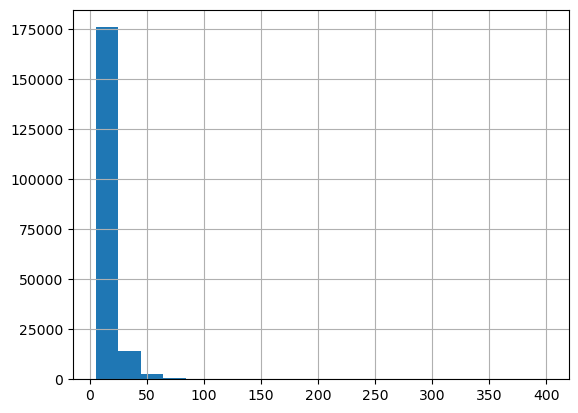

In [21]:
ride_ids["actual_ride_cost"].hist(bins=20)

Now creating a master dataset with all the 3 datasets joined to one

In [22]:
ride_timestamps.pivot(index="ride_id", columns="event", values="timestamp")

event                                     accepted_at           arrived_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:51  2016-06-13 09:44:31   
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:25  2016-05-14 05:26:17   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:14  2016-05-16 15:47:29   
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:29:43  2016-05-11 19:35:11   
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:12:15  2016-04-26 18:16:52   
...                                               ...                  ...   
fffebb46effb90ce758fdff68b569355  2016-06-16 09:57:12  2016-06-16 09:58:54   
ffff9c38173ddfa17bdd115c463e329f  2016-06-03 18:34:07  2016-06-03 18:35:20   
ffff9e431f7fade54b2550ac19ab6e64  2016-06-12 04:00:10  2016-06-12 04:04:35   
ffffa07f48f2f885f714765d794ad596  2016-04-19 01:09:12  2016-04-19 01:10:49   
ffffccd77f47a3de26dfed9a851464b4  2016-05-18 08:44:21  2016-05-18 08:44:36   

event                                  dropped_off_at         picked_up_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 10:03:05  2016-06-13 09:44:33   
00005eae40882760d675da5effb89ae3  2016-05-14 05:34:17  2016-05-14 05:26:18   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:54:18  2016-05-16 15:47:32   
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:40:47  2016-05-11 19:35:15   
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:24:14  2016-04-26 18:16:55   
...                                               ...                  ...   
fffebb46effb90ce758fdff68b569355  2016-06-16 10:15:08  2016-06-16 09:58:57   
ffff9c38173ddfa17bdd115c463e329f  2016-06-03 18:50:08  2016-06-03 18:35:22   
ffff9e431f7fade54b2550ac19ab6e64  2016-06-12 04:15:42  2016-06-12 04:04:37   
ffffa07f48f2f885f714765d794ad596  2016-04-19 01:30:48  2016-04-19 01:10:50   
ffffccd77f47a3de26dfed9a851464b4  2016-05-18 09:11:37  2016-05-18 08:44:42   

event                                    requested_at  
ride_id                                                
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:19  
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:21  
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:09  
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:29:36  
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:11:38  
...                                               ...  
fffebb46effb90ce758fdff68b569355  2016-06-16 09:57:07  
ffff9c38173ddfa17bdd115c463e329f  2016-06-03 18:34:00  
ffff9e431f7fade54b2550ac19ab6e64  2016-06-12 04:00:10  
ffffa07f48f2f885f714765d794ad596  2016-04-19 01:08:57  
ffffccd77f47a3de26dfed9a851464b4  2016-05-18 08:44:13  

[194081 rows x 5 columns]

In [49]:
temp_df = pd.merge(ride_ids,ride_timestamps.pivot(index="ride_id", columns="event", values="timestamp"), on ="ride_id", how="left")
final_df = pd.merge(temp_df, driver_ids, on = "driver_id", how="left")
final_df

driver_id                           ride_id  \
0       002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1       002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2       002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3       002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4       002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   
...                                  ...                               ...   
193497  ffff51a71f2f185ec5e97d59dbcd7a78  fc717192b3512767269ff5a54b97af05   
193498  ffff51a71f2f185ec5e97d59dbcd7a78  fd6fa5f9265d2cf83936ead663f9e0e7   
193499  ffff51a71f2f185ec5e97d59dbcd7a78  fe0857c43025264d337dfe1d8463e503   
193500  ffff51a71f2f185ec5e97d59dbcd7a78  ff0db0ca4557bf5b05b4da6f660a1ac1   
193501  ffff51a71f2f185ec5e97d59dbcd7a78  ff7dc29693f8c79ff103d350a7b6c157   

        ride_distance  ride_duration  ride_prime_time  actual_ride_cost  \
0                1811            327               50          8.488488   
1                3362            809                0          9.117306   
2                3282            572                0          8.191174   
3               65283           3338               25         77.826485   
4                4115            823              100         17.662788   
...               ...            ...              ...               ...   
193497          10127           1336                0         15.880864   
193498           1908            445                0          6.744265   
193499           4039            875                0          9.842785   
193500           4760            777                0          9.998354   
193501           3751            889              100         17.626887   

                accepted_at           arrived_at       dropped_off_at  \
0       2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1       2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2       2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3       2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4       2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   
...                     ...                  ...                  ...   
193497  2016-06-18 01:15:52  2016-06-18 01:21:11  2016-06-18 01:43:30   
193498  2016-06-23 23:52:08  2016-06-23 23:59:04  2016-06-24 00:06:33   
193499  2016-05-31 19:26:42  2016-05-31 19:29:08  2016-05-31 19:43:46   
193500  2016-05-15 00:51:59  2016-05-15 00:52:05  2016-05-15 01:05:04   
193501  2016-05-15 21:08:55  2016-05-15 21:11:26  2016-05-15 21:26:18   

               picked_up_at         requested_at  driver_onboard_date  
0       2016-04-23 02:16:40  2016-04-23 02:13:50  2016-03-29 00:00:00  
1       2016-03-29 19:04:01  2016-03-29 19:00:49  2016-03-29 00:00:00  
2       2016-06-21 12:01:35  2016-06-21 11:56:31  2016-03-29 00:00:00  
3       2016-05-19 09:18:20  2016-05-19 09:15:29  2016-03-29 00:00:00  
4       2016-04-20 22:07:02  2016-04-20 22:05:30  2016-03-29 00:00:00  
...                     ...                  ...                  ...  
193497  2016-06-18 01:21:14  2016-06-18 01:14:52  2016-05-04 00:00:00  
193498  2016-06-23 23:59:08  2016-06-23 23:51:55  2016-05-04 00:00:00  
193499  2016-05-31 19:29:11  2016-05-31 19:26:34  2016-05-04 00:00:00  
193500  2016-05-15 00:52:07  2016-05-15 00:51:53  2016-05-04 00:00:00  
193501  2016-05-15 21:11:29  2016-05-15 21:08:47  2016-05-04 00:00:00  

[193502 rows x 12 columns]

In [50]:
#creating more ride specific features

# converting distance to kms 
final_df["ride_distance"] = final_df["ride_distance"]/1000 

# converting duration to minutes 
final_df["ride_duration"] = final_df["ride_duration"]/60

# calculating driver response time in minutes
final_df["response_time"] = (pd.to_datetime(final_df["accepted_at"]) - pd.to_datetime(final_df["requested_at"])).dt.total_seconds()/60

# calculating driver time to arrive
final_df["time_to_arrive"] = (pd.to_datetime(final_df["arrived_at"]) - pd.to_datetime(final_df["accepted_at"])).dt.total_seconds()/60

# calculating driver wait time in minutes
final_df["wait_time"] = (pd.to_datetime(final_df["picked_up_at"]) - pd.to_datetime(final_df["arrived_at"])).dt.total_seconds()/60

# calculating drive time of the day
final_df["ride_time"] = np.where((pd.to_datetime(final_df["accepted_at"]).dt.hour >=6) & (pd.to_datetime(final_df["accepted_at"]).dt.hour < 12 ), "morning_ride", np.where((pd.to_datetime(final_df["accepted_at"]).dt.hour >=12) & (pd.to_datetime(final_df["accepted_at"]).dt.hour < 16 ), "afternoon_ride", np.where((pd.to_datetime(final_df["accepted_at"]).dt.hour >=16) & (pd.to_datetime(final_df["accepted_at"]).dt.hour < 22 ), "evening_ride", "night_ride")))

# segmenting rides by duration
final_df["ride_duration_segment"] = np.where(final_df["ride_distance"] < final_df["ride_distance"].quantile(0.33), "short_ride", (np.where(final_df["ride_distance"] < final_df["ride_distance"].quantile(0.66), "medium_ride", "long_ride")))

final_df["ride_date"] = pd.to_datetime(final_df["accepted_at"]).dt.date

final_df

driver_id                           ride_id  \
0       002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1       002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2       002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3       002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4       002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   
...                                  ...                               ...   
193497  ffff51a71f2f185ec5e97d59dbcd7a78  fc717192b3512767269ff5a54b97af05   
193498  ffff51a71f2f185ec5e97d59dbcd7a78  fd6fa5f9265d2cf83936ead663f9e0e7   
193499  ffff51a71f2f185ec5e97d59dbcd7a78  fe0857c43025264d337dfe1d8463e503   
193500  ffff51a71f2f185ec5e97d59dbcd7a78  ff0db0ca4557bf5b05b4da6f660a1ac1   
193501  ffff51a71f2f185ec5e97d59dbcd7a78  ff7dc29693f8c79ff103d350a7b6c157   

        ride_distance  ride_duration  ride_prime_time  actual_ride_cost  \
0               1.811       5.450000               50          8.488488   
1               3.362      13.483333                0          9.117306   
2               3.282       9.533333                0          8.191174   
3              65.283      55.633333               25         77.826485   
4               4.115      13.716667              100         17.662788   
...               ...            ...              ...               ...   
193497         10.127      22.266667                0         15.880864   
193498          1.908       7.416667                0          6.744265   
193499          4.039      14.583333                0          9.842785   
193500          4.760      12.950000                0          9.998354   
193501          3.751      14.816667              100         17.626887   

                accepted_at           arrived_at       dropped_off_at  \
0       2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1       2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2       2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3       2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4       2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   
...                     ...                  ...                  ...   
193497  2016-06-18 01:15:52  2016-06-18 01:21:11  2016-06-18 01:43:30   
193498  2016-06-23 23:52:08  2016-06-23 23:59:04  2016-06-24 00:06:33   
193499  2016-05-31 19:26:42  2016-05-31 19:29:08  2016-05-31 19:43:46   
193500  2016-05-15 00:51:59  2016-05-15 00:52:05  2016-05-15 01:05:04   
193501  2016-05-15 21:08:55  2016-05-15 21:11:26  2016-05-15 21:26:18   

               picked_up_at         requested_at  driver_onboard_date  \
0       2016-04-23 02:16:40  2016-04-23 02:13:50  2016-03-29 00:00:00   
1       2016-03-29 19:04:01  2016-03-29 19:00:49  2016-03-29 00:00:00   
2       2016-06-21 12:01:35  2016-06-21 11:56:31  2016-03-29 00:00:00   
3       2016-05-19 09:18:20  2016-05-19 09:15:29  2016-03-29 00:00:00   
4       2016-04-20 22:07:02  2016-04-20 22:05:30  2016-03-29 00:00:00   
...                     ...                  ...                  ...   
193497  2016-06-18 01:21:14  2016-06-18 01:14:52  2016-05-04 00:00:00   
193498  2016-06-23 23:59:08  2016-06-23 23:51:55  2016-05-04 00:00:00   
193499  2016-05-31 19:29:11  2016-05-31 19:26:34  2016-05-04 00:00:00   
193500  2016-05-15 00:52:07  2016-05-15 00:51:53  2016-05-04 00:00:00   
193501  2016-05-15 21:11:29  2016-05-15 21:08:47  2016-05-04 00:00:00   

        response_time  time_to_arrive  wait_time     ride_time  \
0            0.416667        2.350000   0.066667    night_ride   
1            0.050000        3.083333   0.066667  evening_ride   
2            0.133333        4.883333   0.050000  morning_ride   
3            0.066667        2.783333   0.000000  morning_ride   
4            0.033333        1.516667  -0.016667    night_ride   
...               ...             ...      

### Data Analysis 

### Q1 - Recommend a Driver's Lifetime Value (i.e., the value of a driver to Lyft over the entire projected lifetime of a driver).

We can answer the above question by taking sum of all the rides fpr each driver

In [41]:
final_df.groupby("driver_id")["actual_ride_cost"].sum().reset_index().sort_values("actual_ride_cost", ascending=False)

driver_id  actual_ride_cost
354  5ccc0e6dc9c7475caf785cdce7b8eb7a      12347.102999
217  3788dc9e91f1548816ce8b5af07ddadc      12301.635989
308  4eb382d1f7d50fae1294964263d1ce82      10779.400376
412  6b65c06851e944351dd285a1eb729499      10706.148917
509  844e9be5a30d8d9c1f8e9ddb086ff717      10611.440729
..                                ...               ...
435  706466935b9e1d04e4e116be7ce90ea9        222.108174
775  d31eded9263eab43f614eecc6a52a0f5        210.429308
922  fd831ca1d79ae5c6fc3a679a22e5b8cf        198.831874
494  7ff85c5c0e9324e28d1e0d0589c364bd         36.056520
475  7b625f643d0775f0ac4898e33235377b         25.687087

[937 rows x 2 columns]

The driver with maximum life time value is driver id - "5ccc0e6dc9c7475caf785cdce7b8eb7a" and the value is $12347.102999

### Q2 - Please answer the following questions:

 a) What are the main factors that affect a driver's lifetime value?
 
 b) What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?

 c) Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?

 d) What actionable recommendations are there for the business?

To answer the Q2a above we need to create drivers aggregated tabel with all the metrics which I think will be valuable 

In [214]:
driver_aggregated = pd.DataFrame()
driver_aggregated["total_ride_count"] = final_df.pivot_table(index="driver_id", aggfunc='size')
driver_aggregated

total_ride_count
driver_id                                         
002be0ffdc997bd5c50703158b7c2491               277
007f0389f9c7b03ef97098422f902e62                31
011e5c5dfc5c2c92501b8b24d47509bc                34
0152a2f305e71d26cc964f8d4411add9               191
01674381af7edd264113d4e6ed55ecda               375
...                                            ...
ff45a18cae7bed6538847cb36e2a3975                67
ff714a67ba8c6a108261cd81e3b77f3a               485
fff482c704d36a1afe8b8978d5486283                35
fffecccc49436c5389075b13209f0dfa               406
ffff51a71f2f185ec5e97d59dbcd7a78               330

[937 rows x 1 columns]

In [215]:
# summing the total revenue from the driver
driver_aggregated["lifetime_value"] = final_df.groupby("driver_id")["actual_ride_cost"].sum()

### summing the ride distance
driver_aggregated["total_ride_distance"] = final_df.groupby("driver_id")["ride_distance"].sum()

### summing the ride distance
driver_aggregated["total_ride_duration"] = final_df.groupby("driver_id")["ride_duration"].sum()

# mean response time by driver
driver_aggregated["avg_response_time"] = final_df.groupby("driver_id")["response_time"].apply(lambda g: g.mean(skipna=True))

# mean time to arrive by driver
driver_aggregated["avg_time_to_arrive"] = final_df.groupby("driver_id")["time_to_arrive"].apply(lambda g: g.mean(skipna=True))

# mean time to arrive by driver
driver_aggregated["avg_wait_time"] = final_df.groupby("driver_id")["wait_time"].apply(lambda g: g.mean(skipna=True))

# mean rides per day
driver_aggregated["avg_rides_per_day"] = final_df.pivot_table(index="driver_id", columns="ride_date", aggfunc='size').fillna(0).mean(axis=1)

# adding ride counts by ride time 
driver_aggregated = pd.merge(driver_aggregated, final_df.pivot_table(index="driver_id", columns="ride_time", aggfunc="size"), on="driver_id", how="left")

# adding ride counts by ride time 
driver_aggregated = pd.merge(driver_aggregated, final_df.pivot_table(index="driver_id", columns="ride_duration_segment", aggfunc="size"), on="driver_id", how="left")
driver_aggregated

total_ride_count  lifetime_value  \
driver_id                                                            
002be0ffdc997bd5c50703158b7c2491               277     3560.056648   
007f0389f9c7b03ef97098422f902e62                31      321.434698   
011e5c5dfc5c2c92501b8b24d47509bc                34      482.299206   
0152a2f305e71d26cc964f8d4411add9               191     2610.189071   
01674381af7edd264113d4e6ed55ecda               375     5379.644866   
...                                            ...             ...   
ff45a18cae7bed6538847cb36e2a3975                67      928.827986   
ff714a67ba8c6a108261cd81e3b77f3a               485     6285.948397   
fff482c704d36a1afe8b8978d5486283                35      380.579655   
fffecccc49436c5389075b13209f0dfa               406     6050.600054   
ffff51a71f2f185ec5e97d59dbcd7a78               330     4579.933147   

                                  total_ride_distance  total_ride_duration  \
driver_id                                                                    
002be0ffdc997bd5c50703158b7c2491             1740.287          3687.300000   
007f0389f9c7b03ef97098422f902e62              117.531           341.616667   
011e5c5dfc5c2c92501b8b24d47509bc              269.653           486.750000   
0152a2f305e71d26cc964f8d4411add9             1471.239          2908.683333   
01674381af7edd264113d4e6ed55ecda             3123.644          5957.383333   
...                                               ...                  ...   
ff45a18cae7bed6538847cb36e2a3975              593.481           926.216667   
ff714a67ba8c6a108261cd81e3b77f3a             2834.765          7374.866667   
fff482c704d36a1afe8b8978d5486283              174.394           461.550000   
fffecccc49436c5389075b13209f0dfa             2924.913          5899.566667   
ffff51a71f2f185ec5e97d59dbcd7a78             2372.018          4477.350000   

                                  avg_response_time  avg_time_to_arrive  \
driver_id                                                                 
002be0ffdc997bd5c50703158b7c2491           0.140132            2.883153   
007f0389f9c7b03ef97098422f902e62           0.197312            2.952688   
011e5c5dfc5c2c92501b8b24d47509bc           0.121569            3.720588   
0152a2f305e71d26cc964f8d4411add9           0.236649            3.908813   
01674381af7edd264113d4e6ed55ecda           0.208800            3.608133   
...                                             ...                 ...   
ff45a18cae7bed6538847cb36e2a3975                NaN                 NaN   
ff714a67ba8c6a108261cd81e3b77f3a           0.177663            2.976426   
fff482c704d36a1afe8b8978d5486283           0.303333            3.835238   
fffecccc49436c5389075b13209f0dfa           0.176929            3.572619   
ffff51a71f2f185ec5e97d59dbcd7a78           0.244848            4.702222   

                                  avg_wait_time  avg_rides_per_day  \
driver_id                                                            
002be0ffdc997bd5c50703158b7c2491       0.087184           3.043956   
007f0389f9c7b03ef97098422f902e62       0.081183           0.340659   
011e5c5dfc5c2c92501b8b24d47509bc       0.068137           0.373626   
0152a2f305e71d26cc964f8d4411add9       0.091885           2.098901   
01674381af7edd264113d4e6ed55ecda       0.136800           4.120879   
...                                         ...                ...   
ff45a18cae7bed6538847cb36e2a3975            NaN                NaN   
ff714a67ba8c6a108261cd81e3b77f3a       0.048144           5.329670   
fff482c704d36a1afe8b8978d5486283       0.034762           0.384615   
fffecccc49436c5389075b13209f0dfa       0.191051           4.461538   
ffff51a71f2f185ec5e97d59dbcd7a78       0.029293           3.626374   

                                  afternoon_ride  evening_ride  morning_ride  \
driver_id                                                                      
002be0ffdc997bd5c50703158b7c2491            24.0         103.

In [216]:
driver_onboard_df = pd.merge(driver_ids, final_df.groupby("driver_id")["accepted_at"].max().reset_index(), "left")
driver_onboard_df["driver_lifetime_days"] = (pd.to_datetime(driver_onboard_df["accepted_at"]) - pd.to_datetime(driver_onboard_df["driver_onboard_date"])).dt.days
driver_onboard_df = driver_onboard_df.drop(columns=['driver_onboard_date', 'accepted_at'])
driver_onboard_df

driver_id  driver_lifetime_days
0    002be0ffdc997bd5c50703158b7c2491                  86.0
1    007f0389f9c7b03ef97098422f902e62                  85.0
2    011e5c5dfc5c2c92501b8b24d47509bc                  68.0
3    0152a2f305e71d26cc964f8d4411add9                  64.0
4    01674381af7edd264113d4e6ed55ecda                  56.0
..                                ...                   ...
932  ff419a3476e21e269e340b5f1f05414e                  61.0
933  ff714a67ba8c6a108261cd81e3b77f3a                  81.0
934  fff482c704d36a1afe8b8978d5486283                  34.0
935  fffecccc49436c5389075b13209f0dfa                  51.0
936  ffff51a71f2f185ec5e97d59dbcd7a78                  53.0

[937 rows x 2 columns]

In [217]:
# adding driver lifetime days
driver_aggregated = pd.merge(driver_aggregated, driver_onboard_df, on="driver_id", how="left")
driver_aggregated = driver_aggregated.reset_index().fillna(0)
driver_aggregated = driver_aggregated.drop(columns = ["index"])
driver_aggregated

driver_id  total_ride_count  lifetime_value  \
0    002be0ffdc997bd5c50703158b7c2491               277     3560.056648   
1    007f0389f9c7b03ef97098422f902e62                31      321.434698   
2    011e5c5dfc5c2c92501b8b24d47509bc                34      482.299206   
3    0152a2f305e71d26cc964f8d4411add9               191     2610.189071   
4    01674381af7edd264113d4e6ed55ecda               375     5379.644866   
..                                ...               ...             ...   
932  ff45a18cae7bed6538847cb36e2a3975                67      928.827986   
933  ff714a67ba8c6a108261cd81e3b77f3a               485     6285.948397   
934  fff482c704d36a1afe8b8978d5486283                35      380.579655   
935  fffecccc49436c5389075b13209f0dfa               406     6050.600054   
936  ffff51a71f2f185ec5e97d59dbcd7a78               330     4579.933147   

     total_ride_distance  total_ride_duration  avg_response_time  \
0               1740.287          3687.300000           0.140132   
1                117.531           341.616667           0.197312   
2                269.653           486.750000           0.121569   
3               1471.239          2908.683333           0.236649   
4               3123.644          5957.383333           0.208800   
..                   ...                  ...                ...   
932              593.481           926.216667           0.000000   
933             2834.765          7374.866667           0.177663   
934              174.394           461.550000           0.303333   
935             2924.913          5899.566667           0.176929   
936             2372.018          4477.350000           0.244848   

     avg_time_to_arrive  avg_wait_time  avg_rides_per_day  afternoon_ride  \
0              2.883153       0.087184           3.043956            24.0   
1              2.952688       0.081183           0.340659             6.0   
2              3.720588       0.068137           0.373626             3.0   
3              3.908813       0.091885           2.098901            19.0   
4              3.608133       0.136800           4.120879            82.0   
..                  ...            ...                ...             ...   
932            0.000000       0.000000           0.000000             0.0   
933            2.976426       0.048144           5.329670            65.0   
934            3.835238       0.034762           0.384615            18.0   
935            3.572619       0.191051           4.461538            40.0   
936            4.702222       0.029293           3.626374             3.0   

     evening_ride  morning_ride  night_ride  long_ride  medium_ride  \
0           103.0          66.0        84.0         79          103   
1            24.0           0.0         1.0          5           15   
2            24.0           5.0         2.0         11           11   
3            17.0          55.0       100.0         99           51   
4             0.0         293.0         0.0        157          111   
..            ...           ...         ...        ...          ...   
932           0.0           0.0        67.0         29           22   
933         164.0         248.0         8.0        160          156   
934           1.0          16.0         0.0         11            7   
935         135.0         125.0       106.0        137          141   
936          73.0          59.0       195.0        119          121   

     short_ride  driver_lifetime_days  
0            95                  86.0  
1            11                  85.0  
2            12                  68.0  
3            41                  64.0  
4           107                  56.0  
..          ...                   ...  
932          16                   0.0  
933         169                  81.0  
934          17                  34.0  
935         128                  51.0  
936          90                  53.0  

[937 rows x 17 columns]

#### Question 2A - What are the main factors that affect a driver's lifetime value? 

In [218]:
driver_aggregated.describe()

total_ride_count  lifetime_value  total_ride_distance  \
count        937.000000      937.000000           937.000000   
mean         206.512273     2794.752785          1436.337935   
std          173.254063     2350.977229          1225.443588   
min            3.000000       25.687087             9.895000   
25%           47.000000      665.033049           350.961000   
50%          200.000000     2576.811189          1237.893000   
75%          316.000000     4268.162334          2170.756000   
max          919.000000    12347.102999          6628.201000   

       total_ride_duration  avg_response_time  avg_time_to_arrive  \
count           937.000000         937.000000          937.000000   
mean           2956.450694           0.178585            3.974605   
std            2497.753299           0.088439            1.874707   
min              28.533333           0.000000            0.000000   
25%             671.783333           0.145977            3.192902   
50%            2753.166667           0.177879            3.931845   
75%            4501.816667           0.216470            4.877687   
max           12996.616667           0.687500           12.045238   

       avg_wait_time  avg_rides_per_day  afternoon_ride  evening_ride  \
count     937.000000         937.000000      937.000000    937.000000   
mean        0.058213           2.167533       33.010672     76.032017   
std         0.122190           1.989723       40.725996     81.385249   
min        -1.387415           0.000000        0.000000      0.000000   
25%         0.026779           0.428571        3.000000     13.000000   
50%         0.049123           2.197802       15.000000     35.000000   
75%         0.109354           3.472527       51.000000    126.000000   
max         0.491954          10.098901      281.000000    404.000000   

       morning_ride  night_ride   long_ride  medium_ride  short_ride  \
count    937.000000  937.000000  937.000000   937.000000  937.000000   
mean      47.008538   50.461046   70.228388    68.156884   68.127001   
std       65.259115   62.533297   58.888704    59.335223   60.681897   
min        0.000000    0.000000    1.000000     1.000000    1.000000   
25%        2.000000    4.000000   19.000000    14.000000   14.000000   
50%       16.000000   24.000000   60.000000    63.000000   60.000000   
75%       69.000000   79.000000  106.000000   103.000000  104.000000   
max      372.000000  466.000000  333.000000   296.000000  313.000000   

       driver_lifetime_days  
count            937.000000  
mean              49.197439  
std               26.662990  
min                0.000000  
25%               31.000000  
50%               53.000000  
75%               71.000000  
max               90.000000

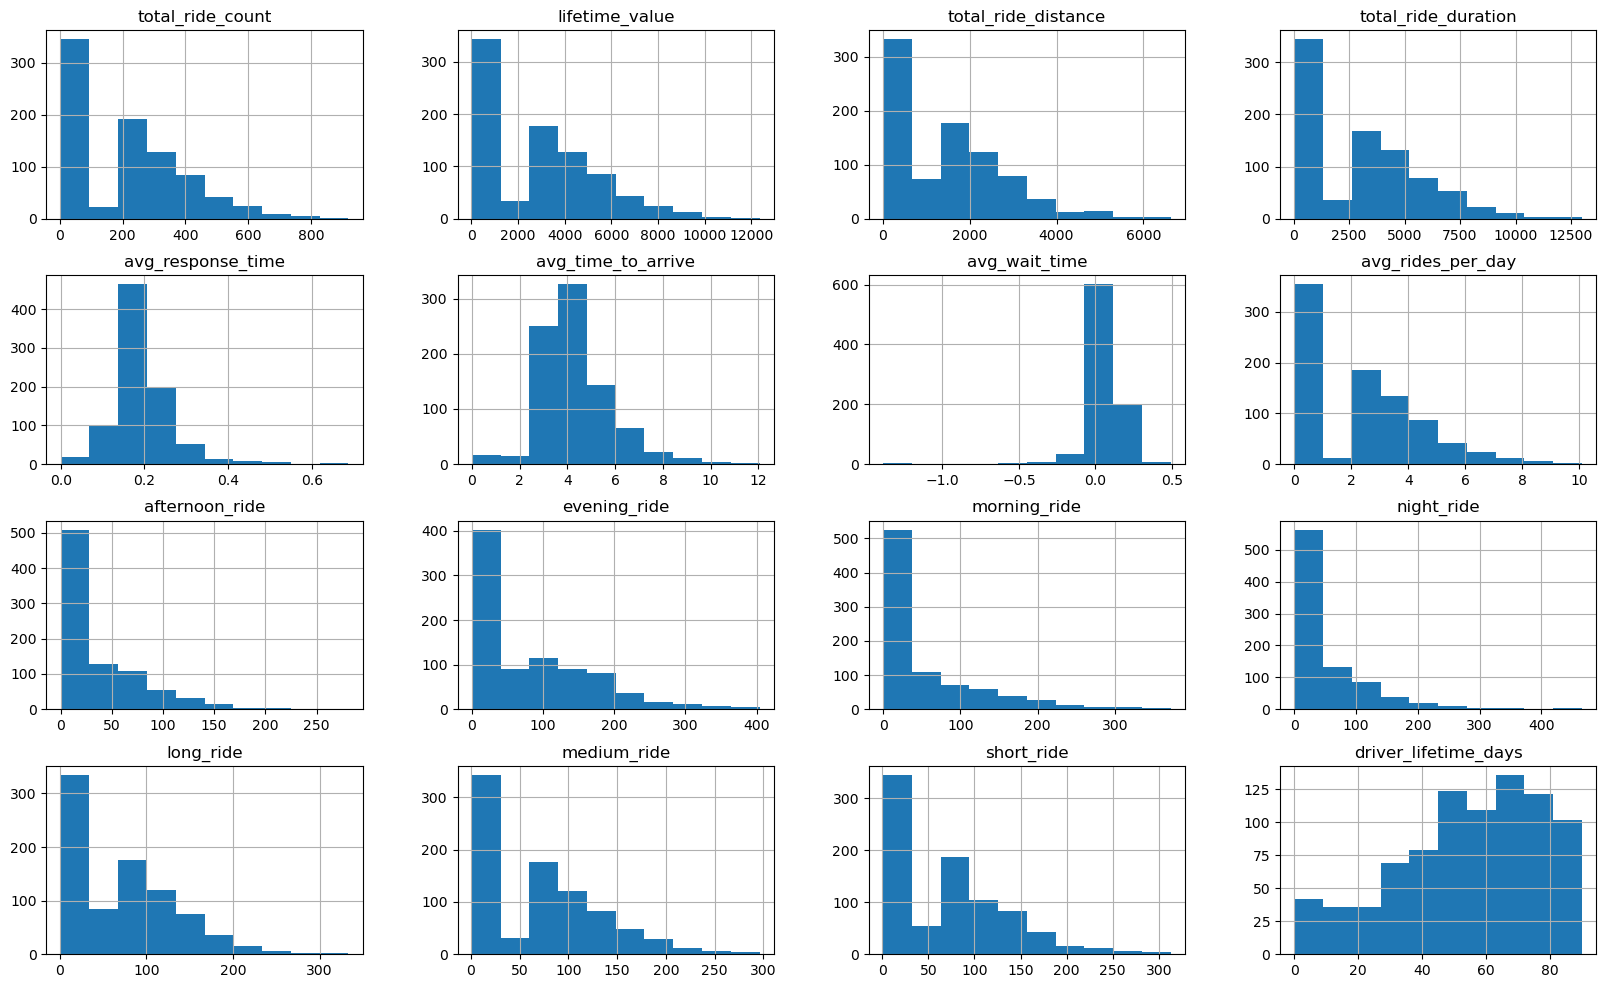

In [201]:
driver_aggregated.hist(figsize=(20,12))
plt.show()

/Users/rithvik/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


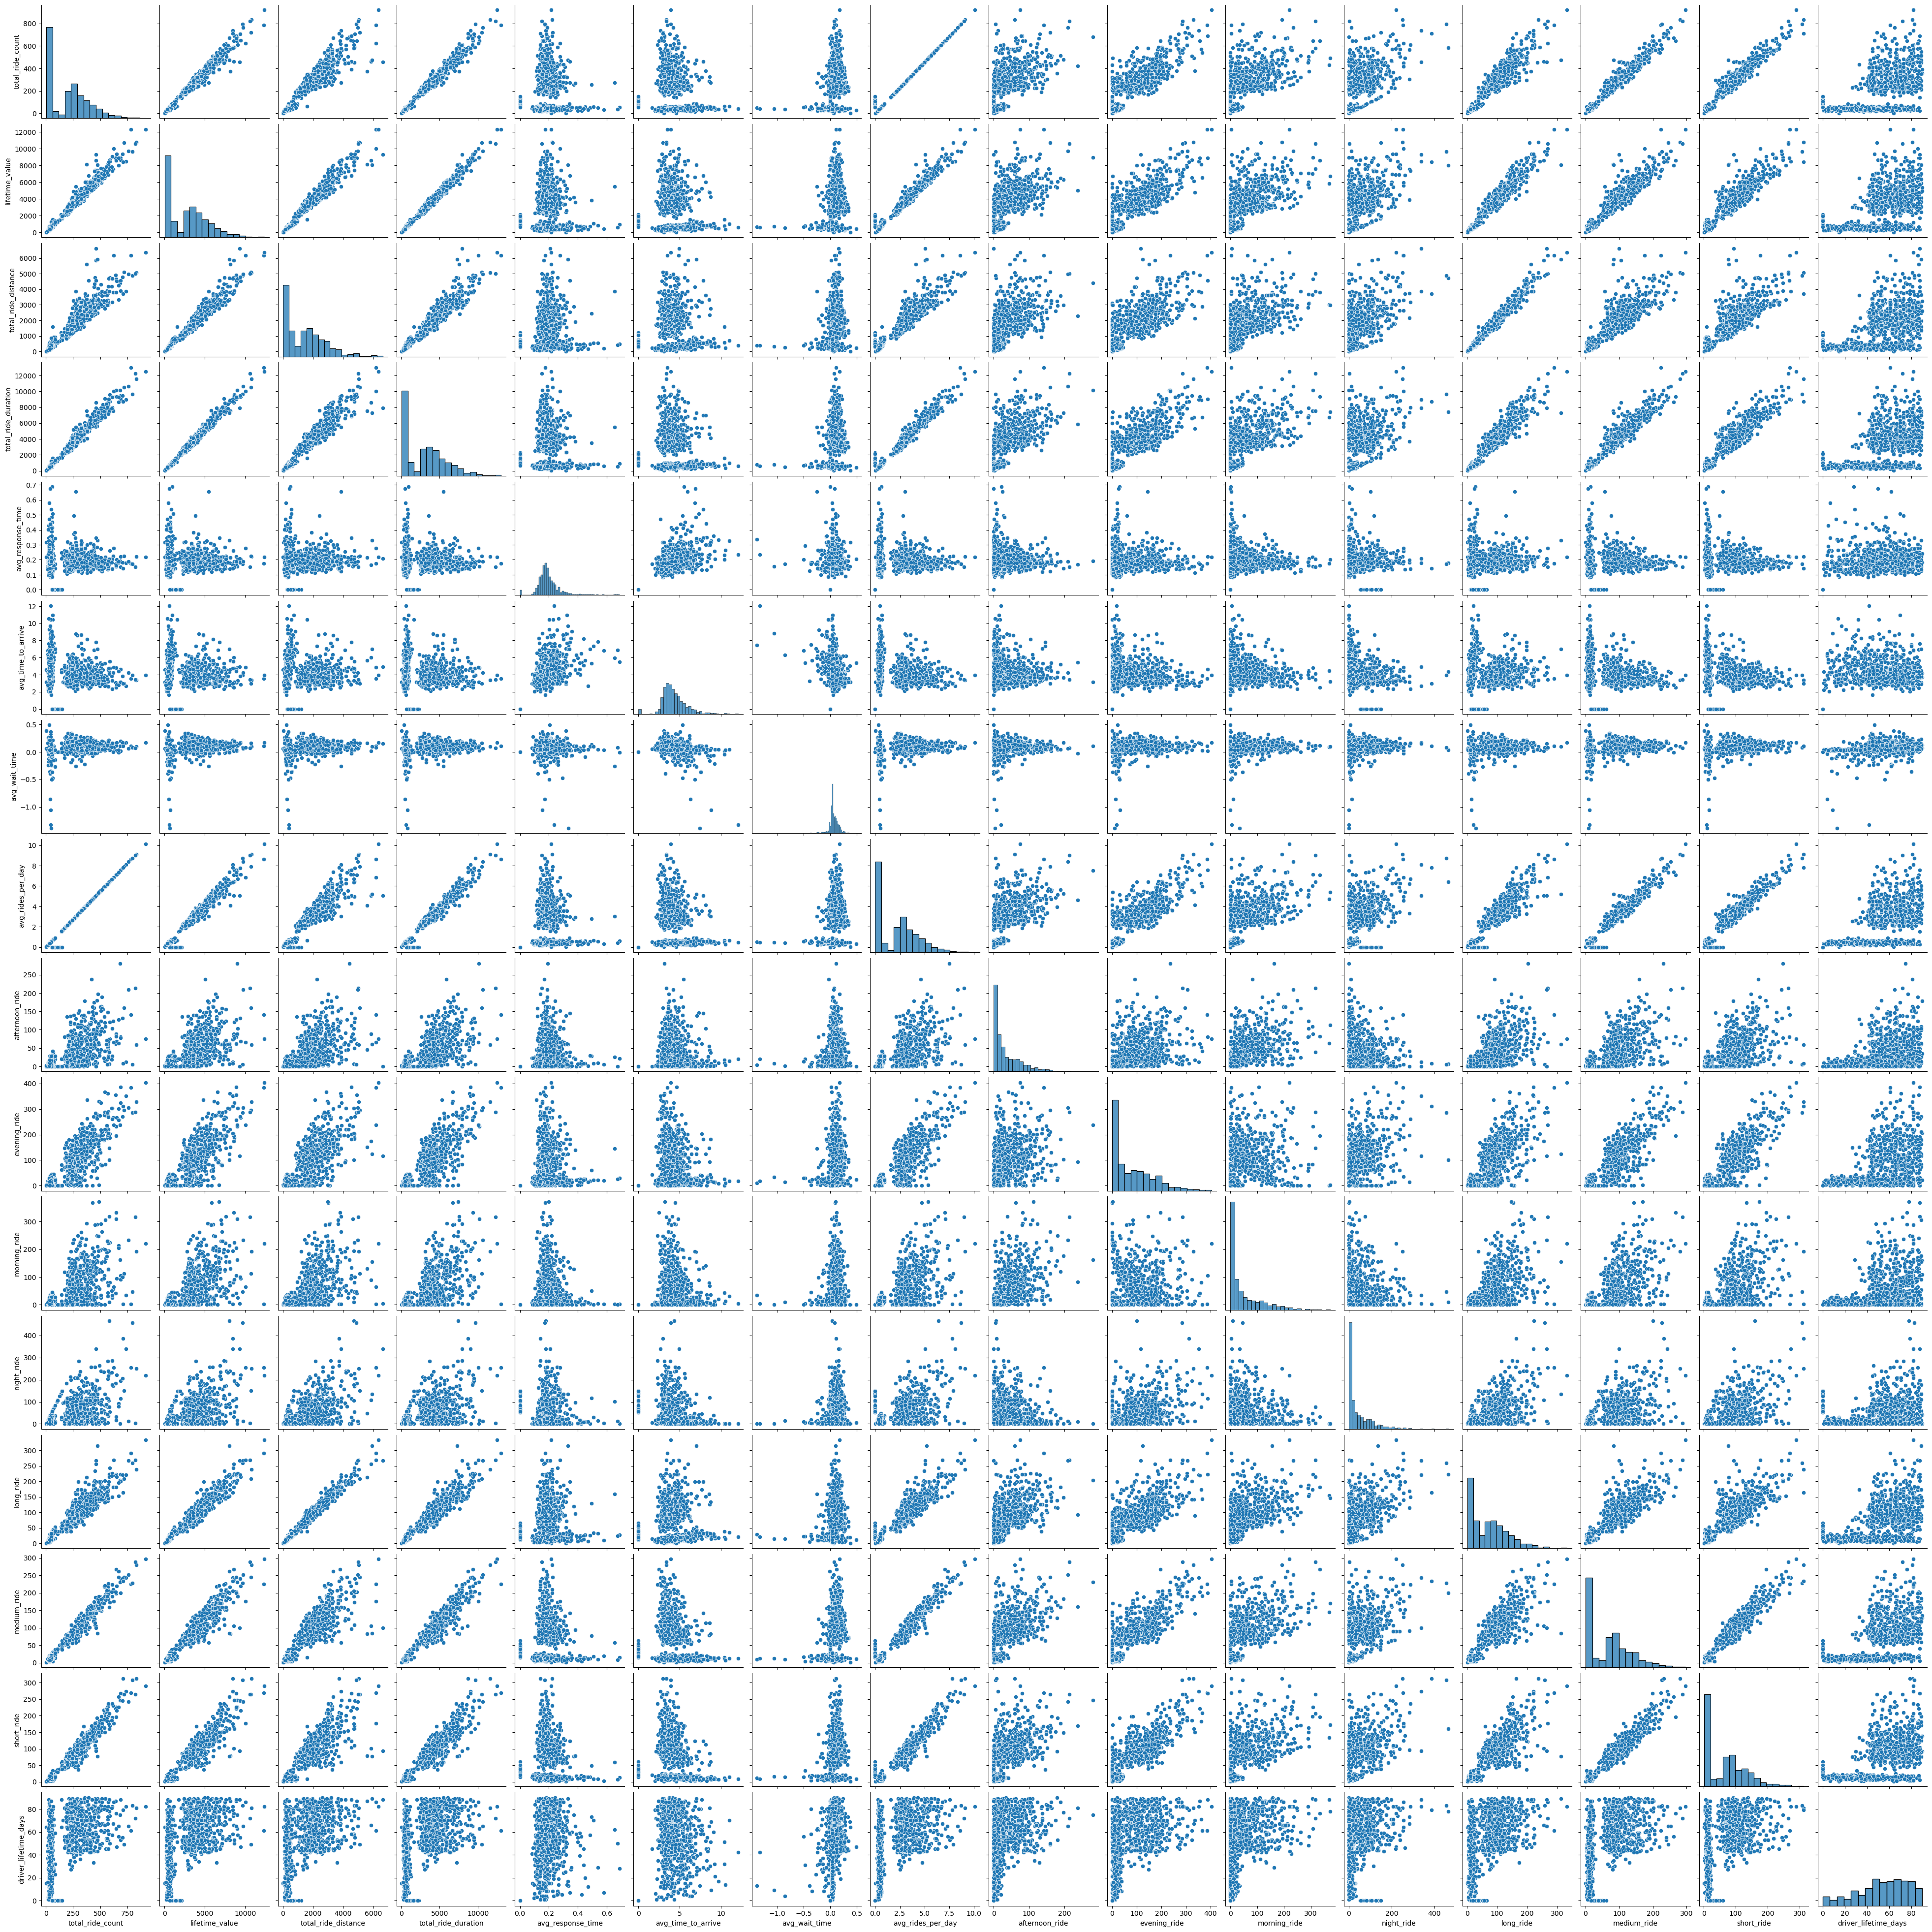

In [202]:
sns.pairplot(driver_aggregated.drop(columns=["driver_id"]))

In [203]:
driver_aggregated.drop(columns=["driver_id"]).corr()

total_ride_count  lifetime_value  total_ride_distance  \
total_ride_count              1.000000        0.987158             0.942849   
lifetime_value                0.987158        1.000000             0.978658   
total_ride_distance           0.942849        0.978658             1.000000   
total_ride_duration           0.988699        0.994237             0.962561   
avg_response_time            -0.032878        0.000730             0.049717   
avg_time_to_arrive           -0.216573       -0.166660            -0.075352   
avg_wait_time                 0.239427        0.231793             0.212053   
avg_rides_per_day             0.996621        0.984389             0.940721   
afternoon_ride                0.656367        0.650585             0.627294   
evening_ride                  0.854397        0.834707             0.777896   
morning_ride                  0.637355        0.632657             0.604492   
night_ride                    0.596546        0.594733             0.588885   
long_ride                     0.944823        0.971473             0.987479   
medium_ride                   0.982268        0.954746             0.884838   
short_ride                    0.976402        0.940749             0.867037   
driver_lifetime_days          0.528920        0.524258             0.521386   

                      total_ride_duration  avg_response_time  \
total_ride_count                 0.988699          -0.032878   
lifetime_value                   0.994237           0.000730   
total_ride_distance              0.962561           0.049717   
total_ride_duration              1.000000          -0.014577   
avg_response_time               -0.014577           1.000000   
avg_time_to_arrive              -0.182079           0.475288   
avg_wait_time                    0.233454          -0.034104   
avg_rides_per_day                0.985690          -0.003594   
afternoon_ride                   0.687808           0.000924   
evening_ride                     0.836143          -0.018113   
morning_ride                     0.656307          -0.017063   
night_ride                       0.548036          -0.051249   
long_ride                        0.957781           0.047848   
medium_ride                      0.965233          -0.068085   
short_ride                       0.948209          -0.073805   
driver_lifetime_days             0.524785           0.135763   

                      avg_time_to_arrive  avg_wait_time  avg_rides_per_day  \
total_ride_count               -0.216573       0.239427           0.996621   
lifetime_value                 -0.166660       0.231793           0.984389   
total_ride_distance            -0.075352       0.212053           0.940721   
total_ride_duration            -0.182079       0.233454           0.985690   
avg_response_time               0.475288      -0.034104          -0.003594   
avg_time_to_arrive              1.000000      -0.307138          -0.183120   
avg_wait_time                  -0.307138       1.000000           0.242570   
avg_rides_per_day              -0.183120       0.242570           1.000000   
afternoon_ride                 -0.034138       0.125042           0.659483   
evening_ride                   -0.188777       0.212104           0.857129   
morning_ride                   -0.088804       0.153592           0.639514   
night_ride                     -0.246604       0.153002           0.579267   
long_ride                      -0.078130       0.208058           0.942223   
medium_ride                    -0.267691       0.244547           0.978416   
short_ride                     -0.280664       0.242271           0.973045   
driver_lifetime_days            0.025855       0.257916           0.549699   

                      afternoon_ride  evening_ride  morning_ride  night_ride  \
total_ride_count            0.656367      0.854397      0.637355    0.596546   
lifetime_value              0.650585      0.834707      0.632657    0.594733   
total_ride_distance   

<Axes: >

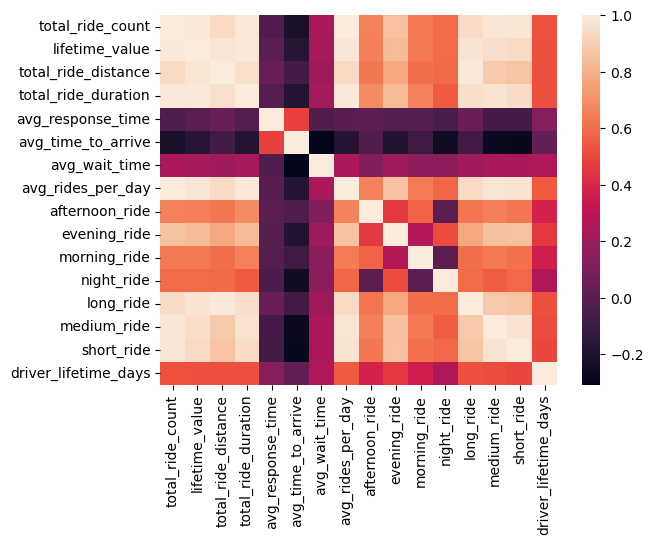

In [204]:
sns.heatmap(driver_aggregated.drop(columns=["driver_id"]).corr())

In [205]:
driver_aggregated.drop(columns=["driver_id"]).corr()["lifetime_value"].sort_values(ascending=False)

lifetime_value          1.000000
total_ride_duration     0.994237
total_ride_count        0.987158
avg_rides_per_day       0.984389
total_ride_distance     0.978658
long_ride               0.971473
medium_ride             0.954746
short_ride              0.940749
evening_ride            0.834707
afternoon_ride          0.650585
morning_ride            0.632657
night_ride              0.594733
driver_lifetime_days    0.524258
avg_wait_time           0.231793
avg_response_time       0.000730
avg_time_to_arrive     -0.166660
Name: lifetime_value, dtype: float64

The main factors that affect a drivers lifetime values are - total_ride_duration, total_ride_count, total_ride_distance, avg_rides_per_day, ride segementation long/med/short (corelated with ride distance)

#### Question 2B - What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?

In [219]:
driver_aggregated["driver_lifetime_days"].mean()

49.1974386339381

The average lifetime of a driver after onboarding is 49 days

#### Question 2C - Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?

In [222]:
driver_aggregated["lifetime_value"].describe() # the mean lifetime value for the driver is $2795

count      937.000000
mean      2794.752785
std       2350.977229
min         25.687087
25%        665.033049
50%       2576.811189
75%       4268.162334
max      12347.102999
Name: lifetime_value, dtype: float64

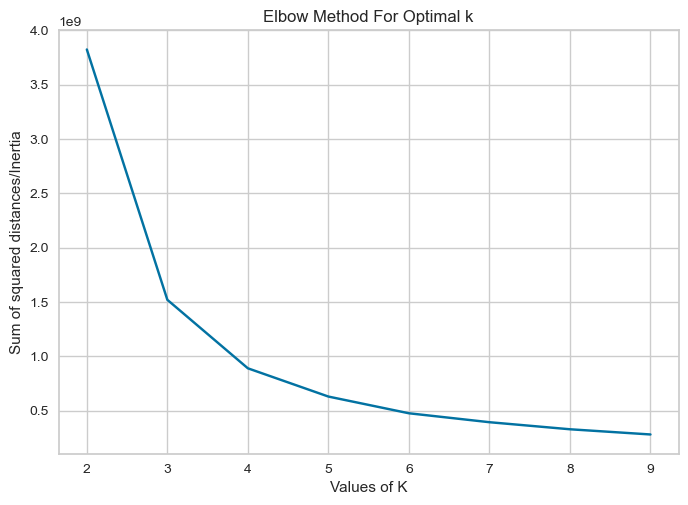

In [243]:
Sum_of_squared_distances = []
K = range(2,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(driver_aggregated.drop(columns=['driver_id']))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

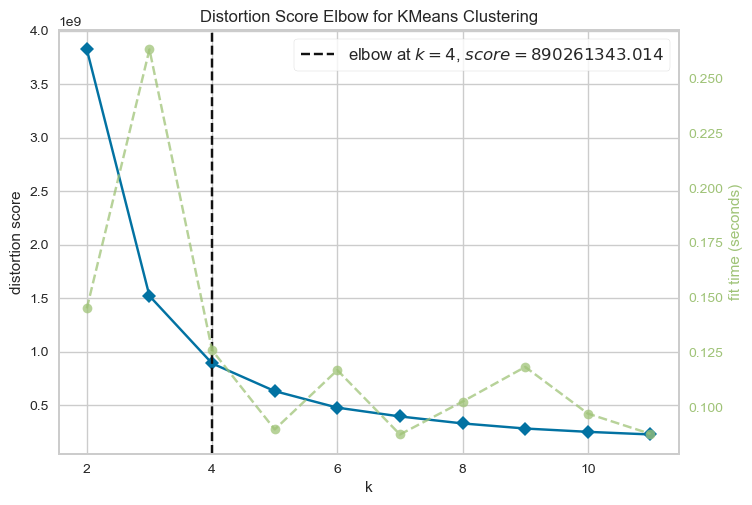

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [245]:
from yellowbrick.cluster import KElbowVisualizer
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Use the KElbowVisualizer to determine the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(driver_aggregated.drop(['driver_id'], axis=1))
visualizer.show()

The number of clusters for this data is 4

In [251]:
km = KMeans(n_clusters=4, random_state=24)
                                                   
km.fit(driver_aggregated.drop(columns=['driver_id']))

KMeans(n_clusters=4, random_state=24)

In [253]:
driver_aggregated["cluster"] = km.labels_
driver_aggregated

driver_id  total_ride_count  lifetime_value  \
0    002be0ffdc997bd5c50703158b7c2491               277     3560.056648   
1    007f0389f9c7b03ef97098422f902e62                31      321.434698   
2    011e5c5dfc5c2c92501b8b24d47509bc                34      482.299206   
3    0152a2f305e71d26cc964f8d4411add9               191     2610.189071   
4    01674381af7edd264113d4e6ed55ecda               375     5379.644866   
..                                ...               ...             ...   
932  ff45a18cae7bed6538847cb36e2a3975                67      928.827986   
933  ff714a67ba8c6a108261cd81e3b77f3a               485     6285.948397   
934  fff482c704d36a1afe8b8978d5486283                35      380.579655   
935  fffecccc49436c5389075b13209f0dfa               406     6050.600054   
936  ffff51a71f2f185ec5e97d59dbcd7a78               330     4579.933147   

     total_ride_distance  total_ride_duration  avg_response_time  \
0               1740.287          3687.300000           0.140132   
1                117.531           341.616667           0.197312   
2                269.653           486.750000           0.121569   
3               1471.239          2908.683333           0.236649   
4               3123.644          5957.383333           0.208800   
..                   ...                  ...                ...   
932              593.481           926.216667           0.000000   
933             2834.765          7374.866667           0.177663   
934              174.394           461.550000           0.303333   
935             2924.913          5899.566667           0.176929   
936             2372.018          4477.350000           0.244848   

     avg_time_to_arrive  avg_wait_time  avg_rides_per_day  afternoon_ride  \
0              2.883153       0.087184           3.043956            24.0   
1              2.952688       0.081183           0.340659             6.0   
2              3.720588       0.068137           0.373626             3.0   
3              3.908813       0.091885           2.098901            19.0   
4              3.608133       0.136800           4.120879            82.0   
..                  ...            ...                ...             ...   
932            0.000000       0.000000           0.000000             0.0   
933            2.976426       0.048144           5.329670            65.0   
934            3.835238       0.034762           0.384615            18.0   
935            3.572619       0.191051           4.461538            40.0   
936            4.702222       0.029293           3.626374             3.0   

     evening_ride  morning_ride  night_ride  long_ride  medium_ride  \
0           103.0          66.0        84.0         79          103   
1            24.0           0.0         1.0          5           15   
2            24.0           5.0         2.0         11           11   
3            17.0          55.0       100.0         99           51   
4             0.0         293.0         0.0        157          111   
..            ...           ...         ...        ...          ...   
932           0.0           0.0        67.0         29           22   
933         164.0         248.0         8.0        160          156   
934           1.0          16.0         0.0         11            7   
935         135.0         125.0       106.0        137          141   
936          73.0          59.0       195.0        119          121   

     short_ride  driver_lifetime_days  cluster  
0            95                  86.0        0  
1            11                  85.0        1  
2            12                  68.0        1  
3            41                  64.0        0  
4           107                  56.0        3  
..          ...                   ...      ...  
932          16                   0.0        1  
933         169                  81.0        3  
934          17                  34.0        1  
935         128                  51.0     

#### Plotting the clusters to understand the attributes

In [272]:
# number of drivers in each cluser 

driver_aggregated.groupby("cluster")["driver_id"].count()

cluster
0    292
1    434
2     56
3    155
Name: driver_id, dtype: int64

Cluster 0 and 1 have the highest population of drivers followed by cluster 3 and then cluster 2

Text(0.5, 0, 'Cluster')

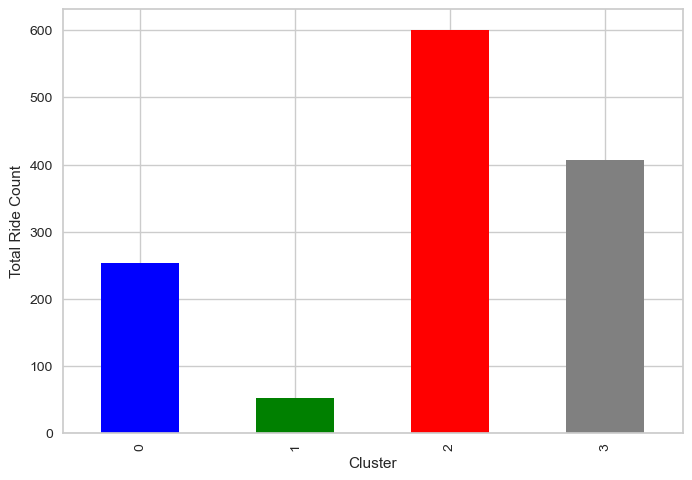

In [348]:
# Total rides
driver_aggregated.groupby("cluster")["total_ride_count"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Total Ride Count')
plt.xlabel('Cluster')

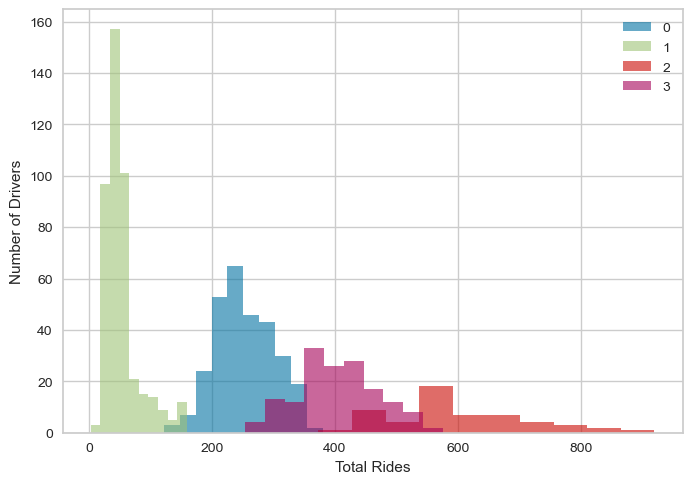

In [317]:
driver_aggregated.groupby("cluster")["total_ride_count"].plot.hist(alpha=0.6)
plt.xlabel('Total Rides')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

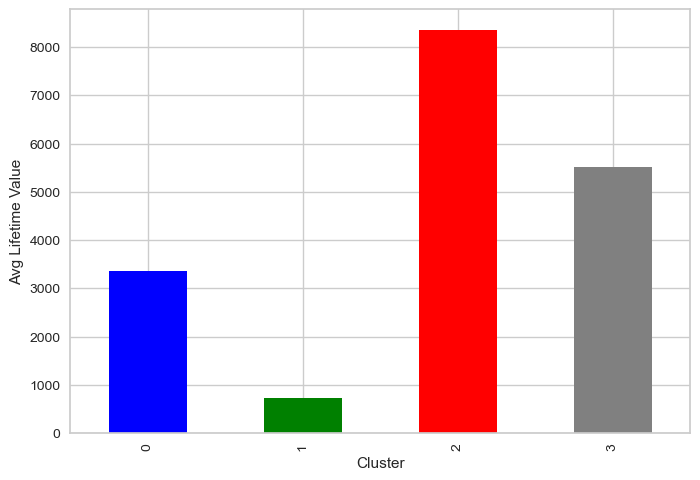

In [347]:
# Lifetime Value
driver_aggregated.groupby("cluster")["lifetime_value"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Lifetime Value')
plt.xlabel('Cluster')

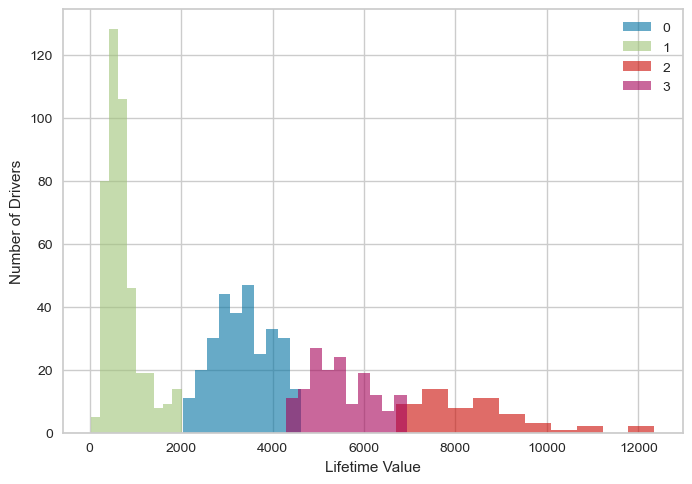

In [319]:
driver_aggregated.groupby("cluster")["lifetime_value"].plot.hist(alpha=0.6)
plt.xlabel('Lifetime Value')
plt.ylabel('Number of Drivers')
plt.legend()

Cluster 2 and 3 are the high average lifetime value generating clusters, cluster 1 is the worst set of drivers followed by cluster 0 who are fair drivers

Text(0.5, 0, 'Cluster')

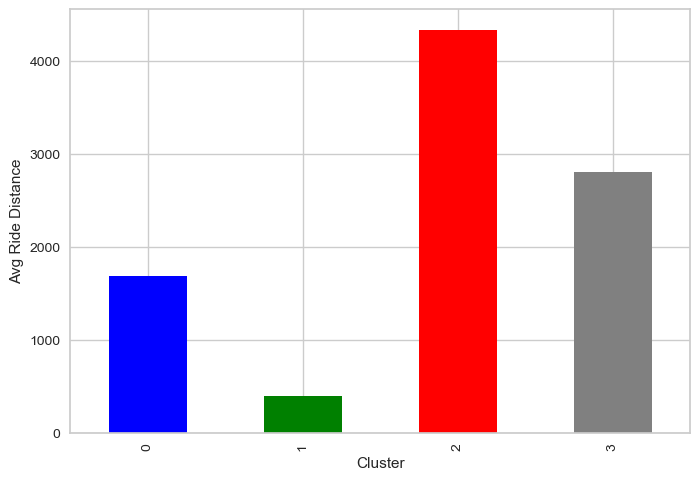

In [320]:
# ride distance
driver_aggregated.groupby("cluster")["total_ride_distance"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Ride Distance')
plt.xlabel('Cluster')

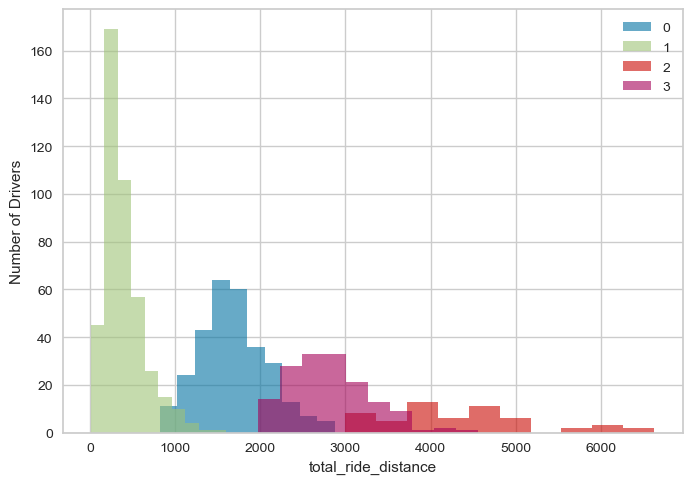

In [321]:
driver_aggregated.groupby("cluster")["total_ride_distance"].plot.hist(alpha=0.6)
plt.xlabel('total_ride_distance')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

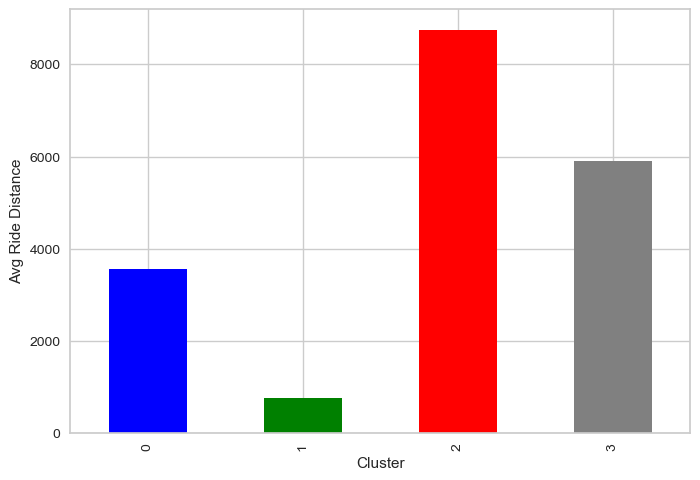

In [322]:
# ride duration
driver_aggregated.groupby("cluster")["total_ride_duration"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Ride Distance')
plt.xlabel('Cluster')

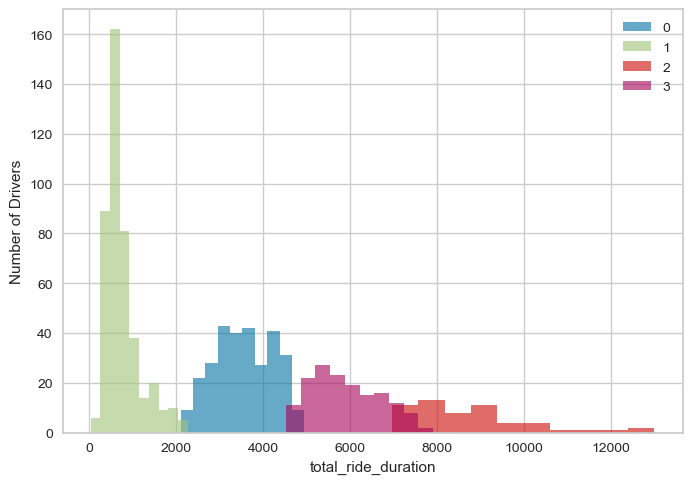

In [323]:
driver_aggregated.groupby("cluster")["total_ride_duration"].plot.hist(alpha=0.6)
plt.xlabel('total_ride_duration')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

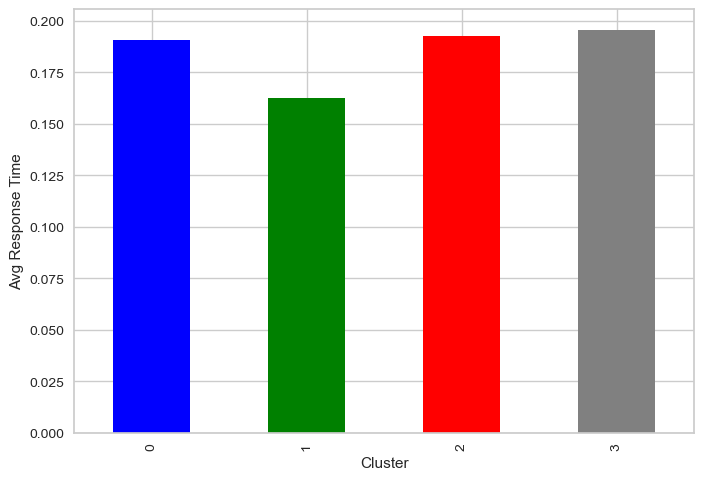

In [324]:
# avg response time
driver_aggregated.groupby("cluster")["avg_response_time"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Response Time')
plt.xlabel('Cluster')

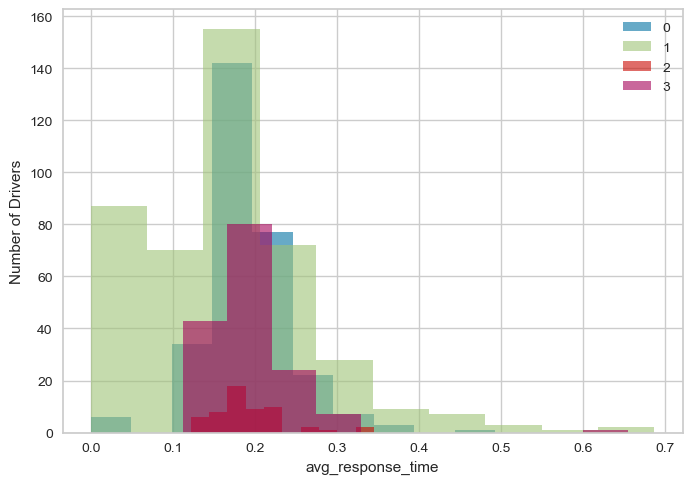

In [325]:
driver_aggregated.groupby("cluster")["avg_response_time"].plot.hist(alpha=0.6)
plt.xlabel('avg_response_time')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

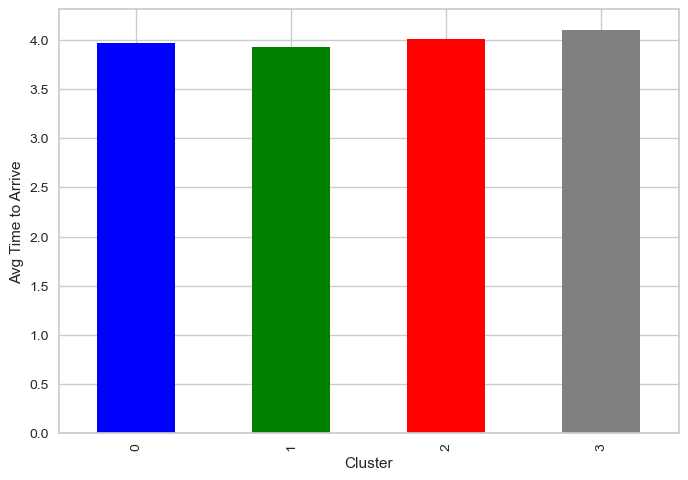

In [326]:
# avg response time
driver_aggregated.groupby("cluster")["avg_time_to_arrive"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Time to Arrive')
plt.xlabel('Cluster')

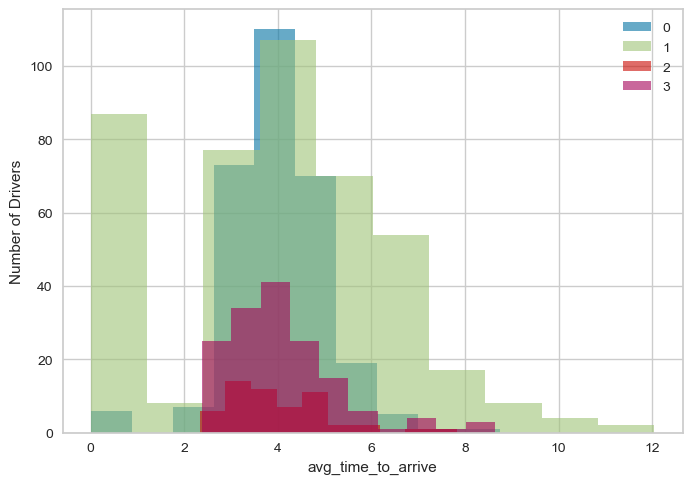

In [327]:
driver_aggregated.groupby("cluster")["avg_time_to_arrive"].plot.hist(alpha=0.6)
plt.xlabel('avg_time_to_arrive')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

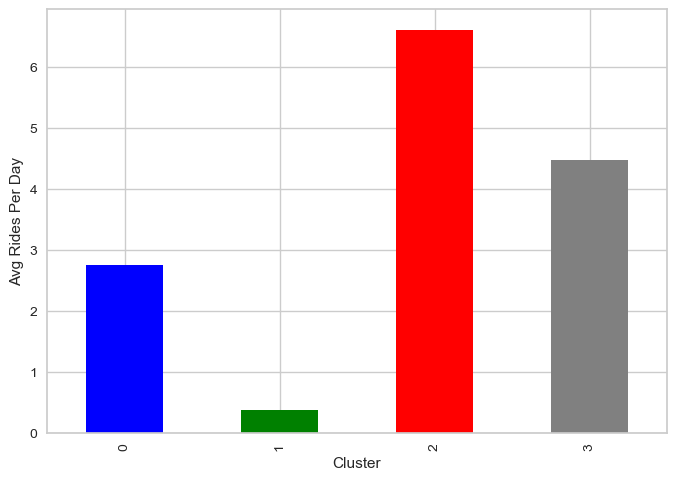

In [328]:
# avg rides per day
driver_aggregated.groupby("cluster")["avg_rides_per_day"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Rides Per Day')
plt.xlabel('Cluster')

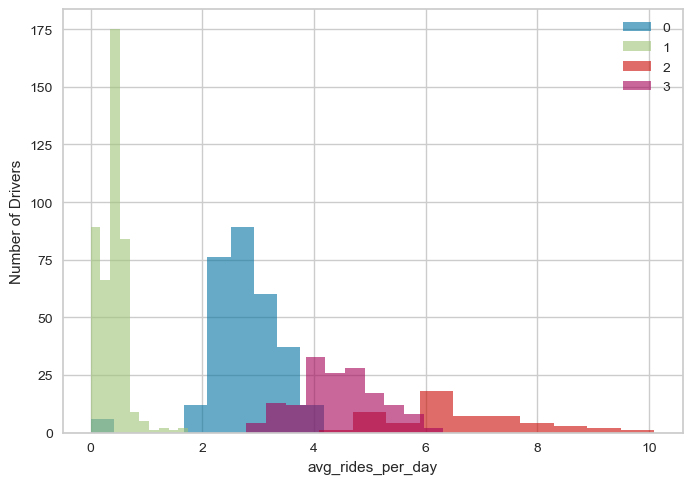

In [329]:
driver_aggregated.groupby("cluster")["avg_rides_per_day"].plot.hist(alpha=0.6)
plt.xlabel('avg_rides_per_day')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

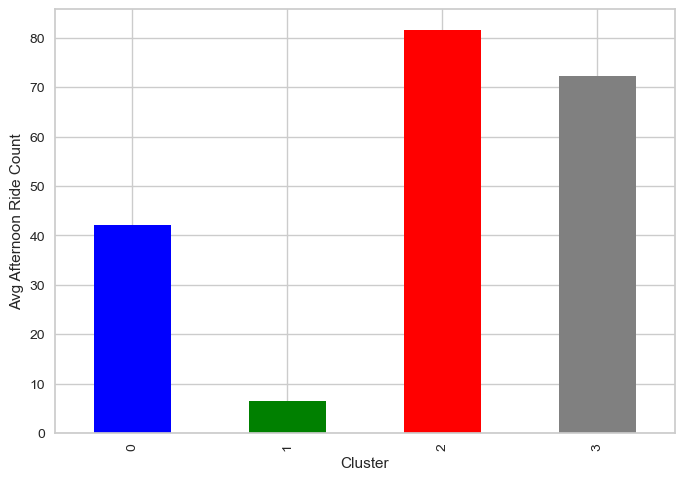

In [330]:
# afternoon rides
driver_aggregated.groupby("cluster")["afternoon_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Afternoon Ride Count')
plt.xlabel('Cluster')

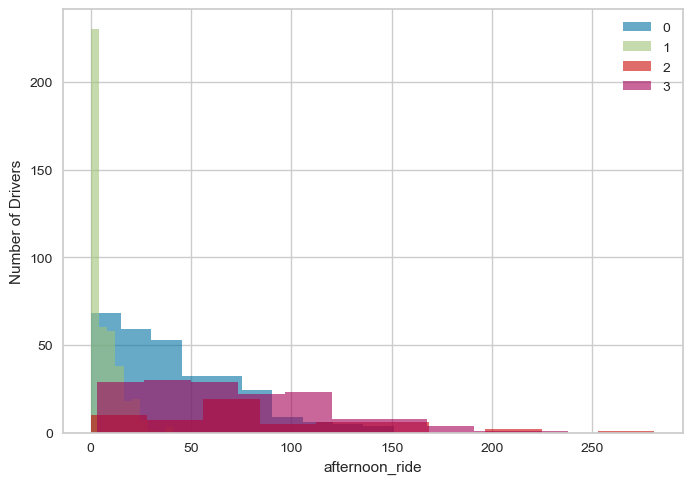

In [331]:
driver_aggregated.groupby("cluster")["afternoon_ride"].plot.hist(alpha=0.6)
plt.xlabel('afternoon_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

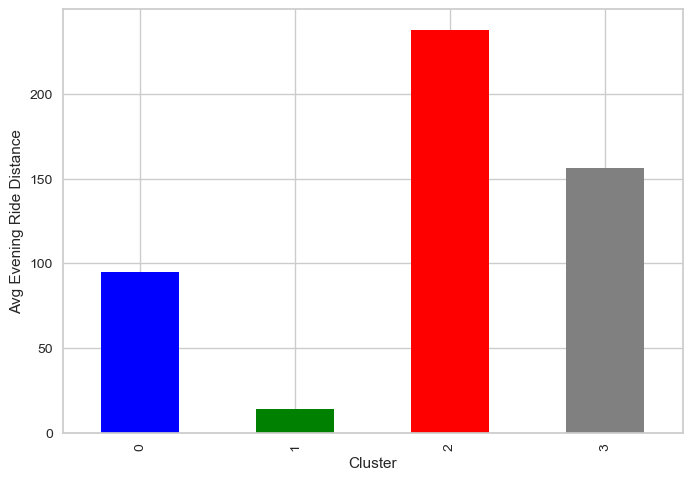

In [332]:
# evening ride
driver_aggregated.groupby("cluster")["evening_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Evening Ride Distance')
plt.xlabel('Cluster')

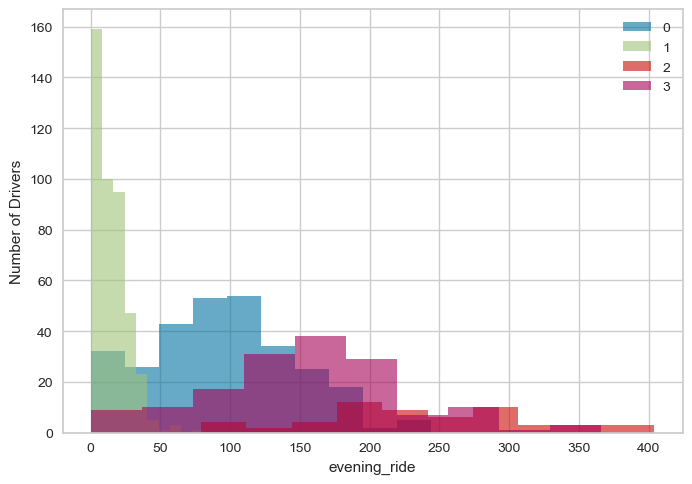

In [333]:
driver_aggregated.groupby("cluster")["evening_ride"].plot.hist(alpha=0.6)
plt.xlabel('evening_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

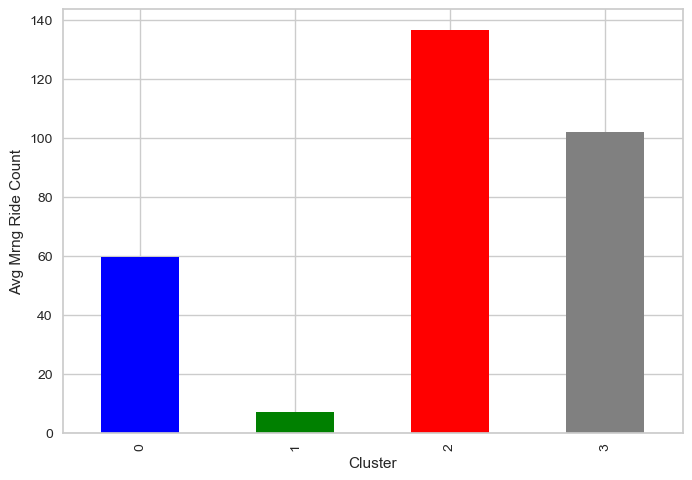

In [334]:
# morning ride
driver_aggregated.groupby("cluster")["morning_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Mrng Ride Count')
plt.xlabel('Cluster')

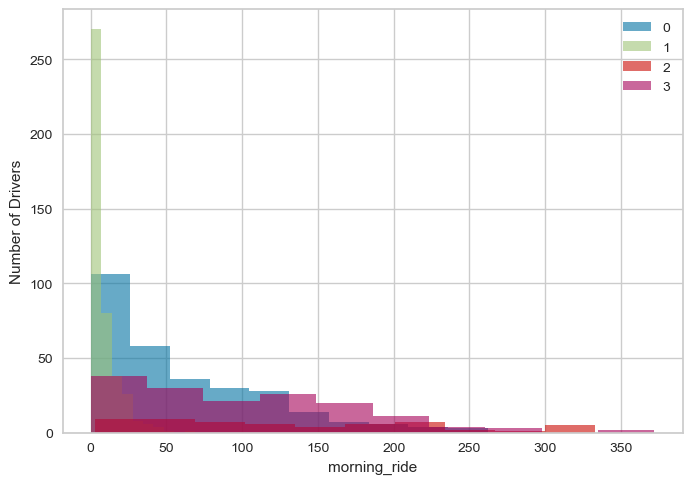

In [335]:
driver_aggregated.groupby("cluster")["morning_ride"].plot.hist(alpha=0.6)
plt.xlabel('morning_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

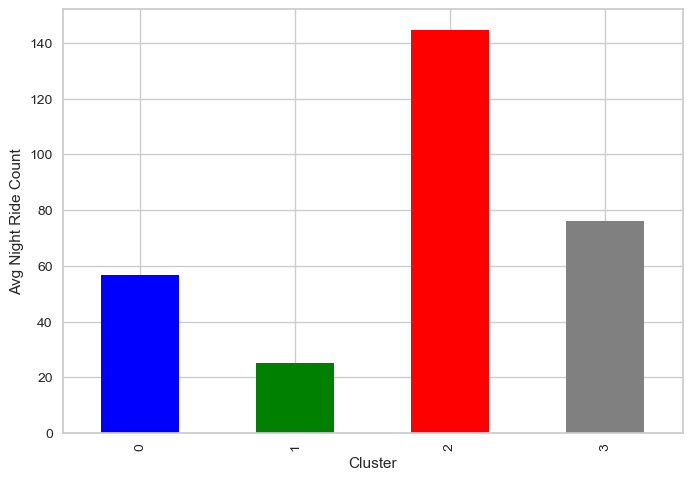

In [336]:
# evening ride
driver_aggregated.groupby("cluster")["night_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Night Ride Count')
plt.xlabel('Cluster')

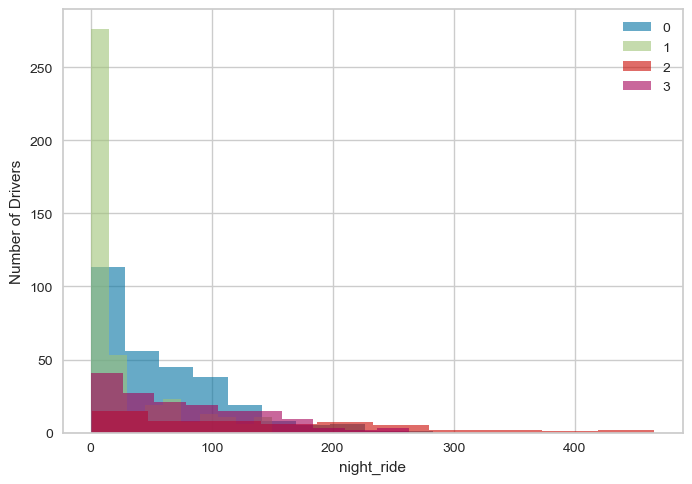

In [337]:
driver_aggregated.groupby("cluster")["night_ride"].plot.hist(alpha=0.6)
plt.xlabel('night_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

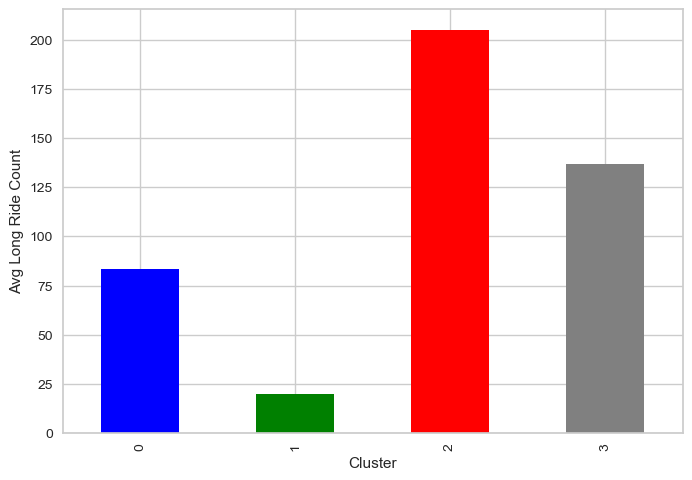

In [338]:
# Long ride
driver_aggregated.groupby("cluster")["long_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Long Ride Count')
plt.xlabel('Cluster')

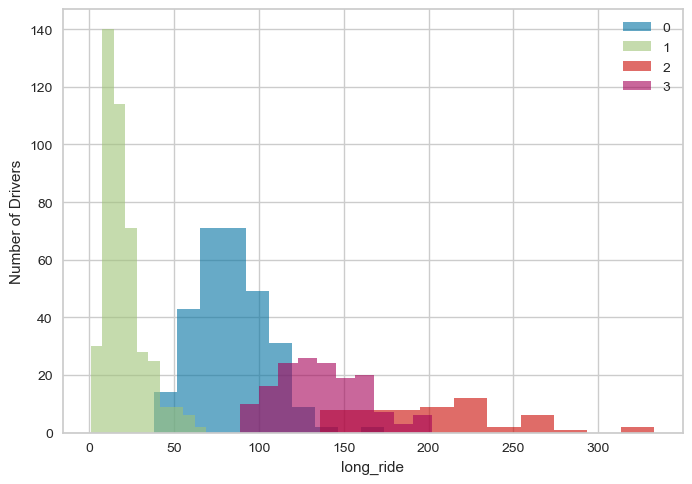

In [340]:
driver_aggregated.groupby("cluster")["long_ride"].plot.hist(alpha=0.6)
plt.xlabel('long_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

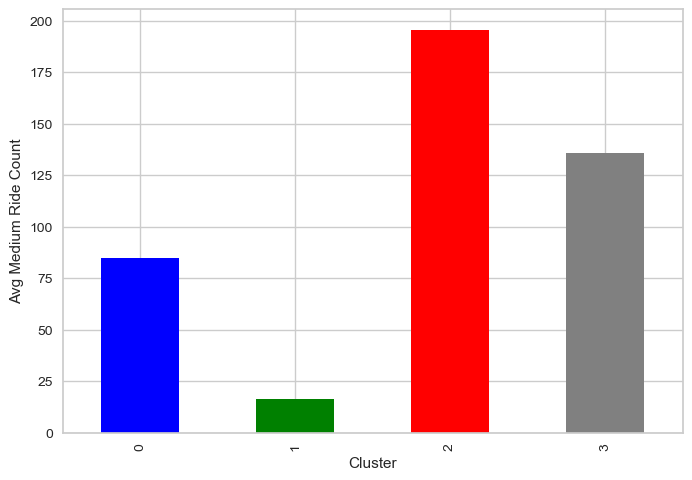

In [341]:
# medium ride
driver_aggregated.groupby("cluster")["medium_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Medium Ride Count')
plt.xlabel('Cluster')

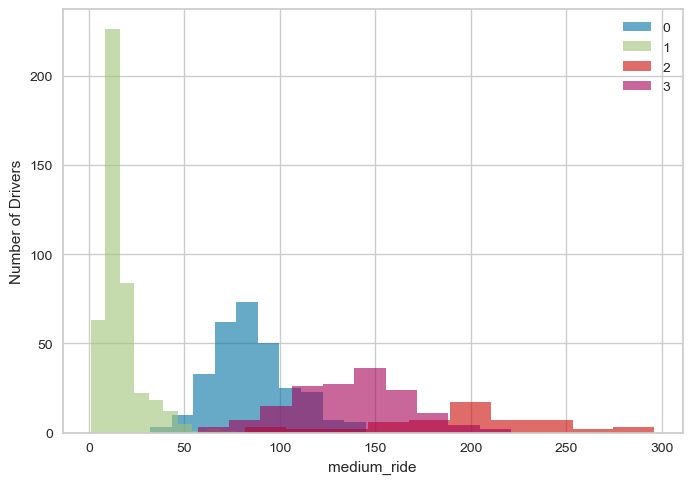

In [342]:
driver_aggregated.groupby("cluster")["medium_ride"].plot.hist(alpha=0.6)
plt.xlabel('medium_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

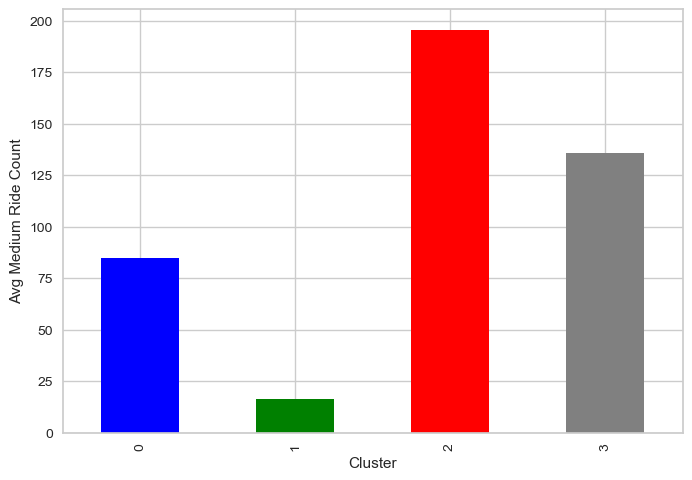

In [341]:
# medium ride
driver_aggregated.groupby("cluster")["medium_ride"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Medium Ride Count')
plt.xlabel('Cluster')

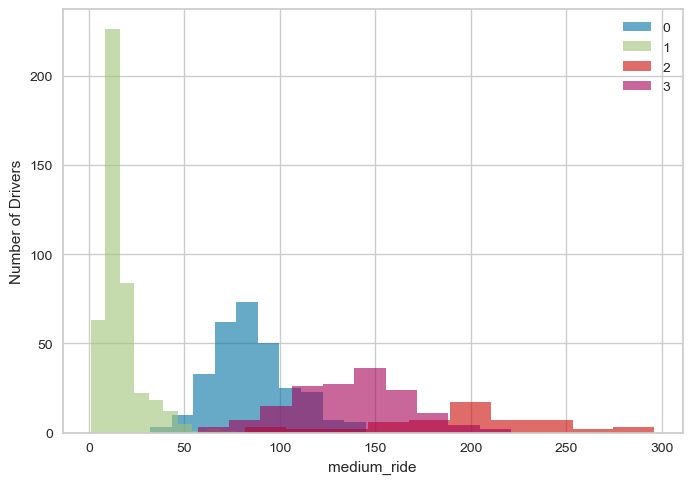

In [342]:
driver_aggregated.groupby("cluster")["medium_ride"].plot.hist(alpha=0.6)
plt.xlabel('medium_ride')
plt.ylabel('Number of Drivers')
plt.legend()

Text(0.5, 0, 'Cluster')

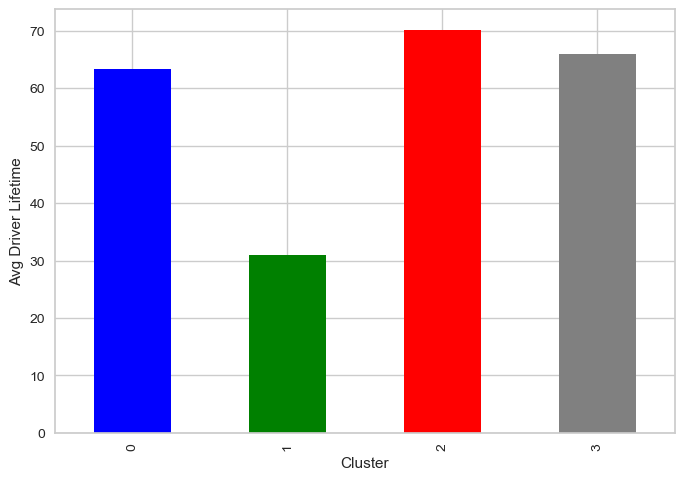

In [343]:
# driver lifetime days
driver_aggregated.groupby("cluster")["driver_lifetime_days"].mean().plot.bar(color = ['blue', 'green', 'red','grey'])
plt.ylabel('Avg Driver Lifetime')
plt.xlabel('Cluster')

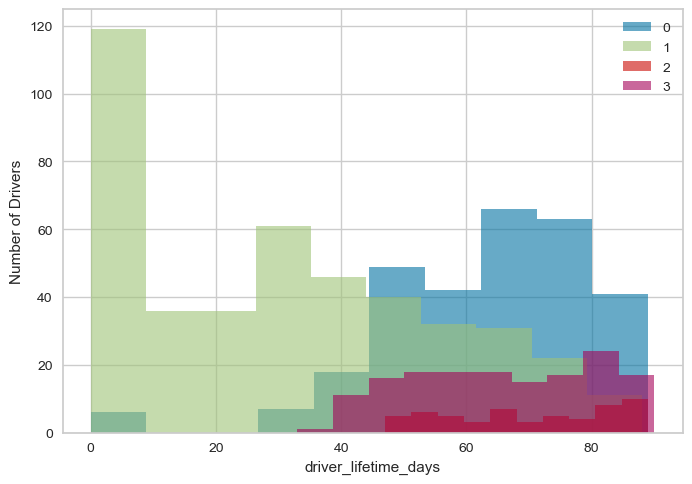

In [344]:
driver_aggregated.groupby("cluster")["driver_lifetime_days"].plot.hist(alpha=0.6)
plt.xlabel('driver_lifetime_days')
plt.ylabel('Number of Drivers')
plt.legend()

Based on the graphs and analysis, here are the most probable cluster definitions and recommendations


- Cluster 0 : These are average drivers with average to below average lifetime values, ride metrics and lifetime with the company. There are 292 drivers in this category. We can provide training or tips to these drivers on how they can improve their metrics and become a good driver. I believe with some training from best/good drivers they can improve and also make more money for themselves and to Lyft. Performance based incentives and daily goals are recommended for this group.

- Cluster 1 : These are worst drivers, there are 434 drivers in this cluster. Majority of the drivers (46%) fall under this cluster. They have the least rides completed and the lowest lifetime value to Lyft. These drivers should be screened more before onboarding with Lyft. We should also collect credit details so that we can eliminate fraud or if they are also working with competitors at the same time. For these drivers, there should be perfomance based payout so that they reach atleast the minimum daily rides. They need extensive training and followups from the company if their ride metrics are not improving. 

- Cluster 2 : These are the best drivers with highest miles driven, duration spent driving, lifetime value, rides completed and also the lifetime with company. The company should treat these drivers as high performers and should be given perks for being highly valuable drivers. There are 53 drivers in this cluster

- Cluster 3 : These are good drivers with more rides completed, good lifetime value and also more days with the company. There are 155 drivers in this category. We can try to motivate these drivers to move to the best drivers cluster by pushing them more and by giving them incentives if their metrics are meeting the best driver cluster averages. 

Thank you, End of Script